In [255]:
import vk
from time import sleep
from tqdm import tqdm
import numpy as np
from matplotlib.colors import LogNorm, rgb2hex
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
import networkx
import seaborn as sns
import nxviz as nv
import networkx as nx
import community
from hiveplot import HivePlot
from itertools import combinations
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)
sns.set_style("white")

На занятии мы будем работать с данными участников Летней Школы, собранные Вконтакте. 

Для работы с API необходимо сгенерировать токен и запустить сессию.

In [2]:
app_id = '5627217'
access_token = '4d351080c90f9b4ede47d88505accc513c61ff97bd451c7d620f18eb67a61815a801080dd9bb3404c0cdf'
session = vk.Session(access_token=access_token)
vkapi = vk.API(session)

In [3]:
with open('vk_users_schoolrr.json', 'r') as f:
    school_users = pd.DataFrame(json.load(f))

In [4]:
with open('school_all_users_connections.json', 'r') as f:
    users_conn = pd.DataFrame(json.load(f))

In [17]:
users_conn.shape

(194254, 13)

In [8]:
countries = pd.DataFrame(vkapi.database.getCountries(need_all=1, count=1000))

In [9]:
countries_dict = dict(zip(countries.cid, countries.title))
countries_dict[0] = None

In [10]:
school_users.fillna(0, inplace=True)

In [12]:
citiesList = []
for key in tqdm(school_users.city.unique()):
    try:
        citiesList.extend(vkapi.database.getCitiesById(city_ids=key, count=500))
        sleep(0.4)
    except Exception as e:
        print(e)
        sleep(3)
        


  0%|          | 0/682 [00:00<?, ?it/s]

10. Internal server error: Database problems, try later. request_params = {'count': '500', 'method': 'database.getCitiesById', 'city_ids': '2.0', 'oauth': '1'}



  1%|▏         | 9/682 [00:07<07:08,  1.57it/s]

10. Internal server error: Database problems, try later. request_params = {'count': '500', 'method': 'database.getCitiesById', 'city_ids': '21611.0', 'oauth': '1'}



  1%|▏         | 10/682 [00:10<15:14,  1.36s/it]

KeyboardInterrupt: 

In [21]:
cities = pd.DataFrame(citiesList).reset_index()
cities_dict = dict(zip(cities.cid, cities.name))
cities_dict[0] = None

In [10]:
school_users['country_name'] = school_users['country'].apply(lambda x: countries_dict[x])

In [11]:
school_users['city'] = school_users['city'].astype(int)

In [12]:
school_users['city_name'] = school_users['city'].apply(lambda x: cities_dict[x])

## Данные

### Информация об участниках

Мы будем работать непосредтсвенно с информацией о самих участниках группы Летней Школы и их связями с другими участниками. В school_users_info.csv представлена необходимая информация об участниках, а в school_connections.csv связи с участниками.

In [14]:
school_users = pd.read_csv('school_users_info.csv', index_col=0)

In [16]:
school_users.head()

,activity,bdate,can_post,can_see_all_posts,can_write_private_message,city,country,deactivated,faculty,faculty_name,first_name,graduation,has_mobile,home_phone,last_name,mobile_phone,nickname,online,online_app,online_mobile,photo,photo_big,photo_medium,relation,relation_partner,screen_name,sex,status_audio,timezone,uid,university,university_name,country_name,city_name,occupation_type,occupation_name,Source,friends_count,pages_count,followers_count,bdate_year
0,NaN,29.9.1987,1,1.0,1,2,1.0,0,2157467.0,Институт энергетики и транспортных систем,Katya,2010.0,1.0,0,Yushkevich,0,NaN,0,0,0.0,https://pp.userapi.com/c639531/v639531657/237c...,https://pp.userapi.com/c639531/v639531657/237c...,https://pp.userapi.com/c639531/v639531657/237c...,0.0,0,id657,1,0,0.0,657,56.0,СПбПУ Петра Великого (Политех),Russia,Saint Petersburg,university,СПбПУ Петра Великого (Политех),657,860.0,40.0,1051.0,1987
1,что-нибудь такое,12.6.1986,0,0.0,1,2,1.0,0,7.0,Математико-механический факультет,Anna,2009.0,1.0,0,Golikova,0,NaN,0,0,0.0,https://pp.userapi.com/c836223/v836223882/2d41...,https://pp.userapi.com/c836223/v836223882/2d41...,https://pp.userapi.com/c836223/v836223882/2d41...,1.0,0,golikova,1,0,0.0,882,1.0,СПбГУ,Russia,Saint Petersburg,work,CleverCine,882,903.0,372.0,6198.0,1986
2,liberal science&amp;arts+co-learning=new level...,28.6,0,0.0,0,2,1.0,0,0.0,0,Alina,0.0,1.0,0,Yashina,0,NaN,0,0,0.0,https://pp.userapi.com/c637216/v637216905/4fc3...,https://pp.userapi.com/c637216/v637216905/4fc3...,https://pp.userapi.com/c637216/v637216905/4fc3...,0.0,0,alisha_ya,1,0,0.0,905,0.0,0,Russia,Saint Petersburg,work,Liberal Arts Lab,905,1202.0,379.0,2483.0,0
3,I don't need to work out. My anxiety acts as a...,18.8,0,0.0,0,2,1.0,0,6.0,Институт истории (бывш. Исторический факультет),Masha,0.0,1.0,0,Egorova,0,NaN,0,0,0.0,https://pp.userapi.com/c10566/u01422/e_f62f50b...,https://pp.userapi.com/c10566/u01422/a_09cc6b8...,https://pp.userapi.com/c10566/u01422/d_86656bd...,1.0,0,masha.egorova,1,0,0.0,1422,1.0,СПбГУ,Russia,Saint Petersburg,work,Политехнический музей,1422,439.0,153.0,1068.0,0
4,Жду вас в своей фотогруппе: @karpova_foto . Вс...,7.2,0,0.0,1,2,1.0,0,0.0,0,Elena,0.0,1.0,0,Karpova,0,NaN,0,0,0.0,https://pp.userapi.com/c637330/v637330450/311e...,https://pp.userapi.com/c637330/v637330450/311e...,https://pp.userapi.com/c637330/v637330450/311e...,0.0,0,karmannoe_zlo,1,0,0.0,1450,0.0,0,Russia,Saint Petersburg,work,Karpova Elena | Photography,1450,1185.0,98.0,1696.0,0


### Связи участников внутри группы

# Обзор участников школы

In [18]:
citiesList = []
for key in tqdm(users_conn.city.unique()):
    try:
        citiesList.extend(vkapi.database.getCitiesById(city_ids=key, count=1000))
        sleep(0.4)
    except Exception as e:
        print(e)
        sleep(3)
        


  4%|▍         | 23/559 [00:11<04:16,  2.09it/s]

10. Internal server error: Database problems, try later. request_params = {'count': '1000', 'method': 'database.getCitiesById', 'city_ids': '123.0', 'oauth': '1'}


 11%|█         | 62/559 [00:33<03:54,  2.12it/s]

10. Internal server error: Database problems, try later. request_params = {'count': '1000', 'method': 'database.getCitiesById', 'city_ids': '122.0', 'oauth': '1'}


100%|██████████| 559/559 [04:42<00:00,  2.05it/s]


In [19]:
users_conn.fillna(0, inplace=True)

In [28]:
cities_dict[122] = 'Ryazan'

vkapi.database.getCitiesById(city_ids=122, count=1000)

In [29]:
users_conn['city_name'] = users_conn['city'].apply(lambda x: cities_dict[x])

In [143]:
def split_bdate(x):
    try:
        return int(x.split('.')[2])
    except:
        return 0


In [144]:
school_users['bdate_year'] = school_users['bdate'].apply(lambda x: split_bdate(x))

## География участников

In [165]:
school_users.city_name.value_counts()[:5]

Moscow              4177
Saint Petersburg    1982
Yekaterinburg        319
Novosibirsk          200
Kazan                196
Name: city_name, dtype: int64

сделать карту по россии участников 

In [166]:
school_users.country_name.value_counts()[:5]

Russia     11371
Ukraine      118
Belarus       99
Germany       50
USA           48
Name: country_name, dtype: int64

In [21]:
def get_occupation(x):
    if x:
        return x['type']
    
def get_job(x):
    if x:
        return x['name']

In [22]:
school_users['occupation_type'] = school_users['occupation'].apply(lambda x: get_occupation(x))

In [23]:
school_users['occupation_name'] = school_users['occupation'].apply(lambda x: get_job(x))

In [87]:
school_users.columns

Index(['activity', 'bdate', 'can_post', 'can_see_all_posts',
       'can_write_private_message', 'city', 'counters', 'country',
       'deactivated', 'faculty', 'faculty_name', 'first_name', 'graduation',
       'has_mobile', 'home_phone', 'last_name', 'last_seen', 'mobile_phone',
       'nickname', 'occupation', 'online', 'online_app', 'online_mobile',
       'photo', 'photo_big', 'photo_medium', 'relation', 'relation_partner',
       'screen_name', 'sex', 'status_audio', 'timezone', 'Source',
       'universities', 'university', 'university_name', 'city_name',
       'country_name', 'occupation_type', 'occupation_name'],
      dtype='object')

In [24]:
school_users['Source'] = school_users['uid']

In [30]:
source_users = users_conn[['Source']].merge(school_users[['Source', 'first_name', 'last_name','bdate','sex',
                                                          'city_name', 'pages_count','followers_count','friends_count',
                                           'country_name', 'university_name', 'faculty_name', 
                                           'occupation_type', 'occupation_name', 'bdate_year']], on='Source', how='left')

In [31]:
target_users = users_conn[['uid']].merge(school_users[['uid', 'first_name', 'last_name','bdate',
                                                       'sex','city_name', 'pages_count','followers_count','friends_count', 
                                           'country_name', 'university_name', 'faculty_name', 
                                           'occupation_type', 'occupation_name', 'bdate_year']], on='uid', how='left')

In [32]:
for col in source_users.columns:
    if col != 'Source':
        source_users = source_users.rename(columns={col: "source_{}".format(col)})

In [33]:
source_users = source_users.drop_duplicates()

In [34]:
for col in target_users.columns:
    if col != 'uid':
        target_users = target_users.rename(columns={col: "target_{}".format(col)})

In [35]:
target_users = target_users.drop_duplicates()

In [36]:
users_connections = users_conn[['Source', 'uid']].merge(source_users, on='Source', how='inner')

In [37]:
users_connections = users_connections.merge(target_users, on='uid', how='left')

In [38]:
users_connections = users_connections.rename(columns={"uid": 'Target'})

In [41]:
users_connections.to_csv('school_all_connections.csv')

## Связи в графе

In [42]:
graph = users_connections#.sample(frac=0.01)
G = nx.from_pandas_dataframe(graph, 'Source', 'Target')

In [498]:
graph.shape

(194254, 30)

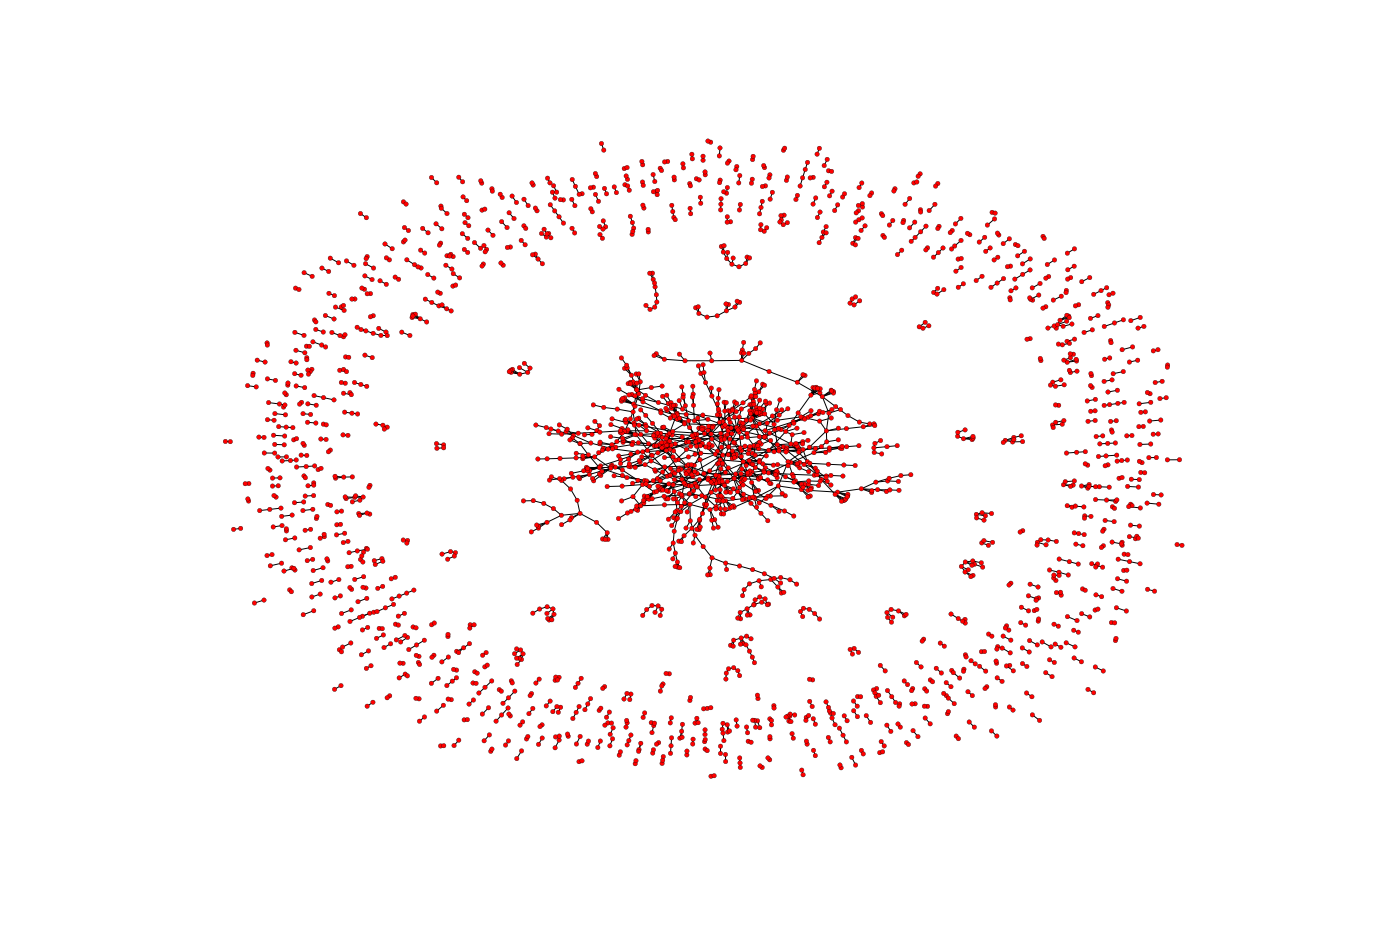

In [486]:
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(24,16))
nx.draw(G, pos, edge_list=G.edges(), ax=ax, node_size=[20 for x in G.nodes()], hold=True)

## Свойства графа

In [72]:
center_g.number_of_nodes()

1334

In [71]:
center_g.number_of_edges()

2084

## Связный граф

In [73]:
nx.is_connected(center_g)

True

Так как наш граф несвязный, в нем можно выделить отдельные связные компоненты и далее анализировать только этим компоненты. 

In [74]:
for x in list(nx.connected_components(center_g)):
    print(len(x))

1334


Мы видим, что на самом деле здесь всего одна крупная компонента, остальные очень маленькие и больше похожи на шум. Отбросим эти компоненты и будем в дальнейшем рассматривать только самую большую компоненту.

In [281]:
small_graph = G.subgraph(np.random.choice(list(list(nx.connected_components(G))[0]), 1000))

In [291]:
small_graph
ccsubgraphs = list(nx.connected_component_subgraphs())
ccsubgraphs

In [295]:
for i, g in enumerate(ccsubgraphs[2:5]):
    for n in g.nodes():
        G.node[n]['subgraph'] = i

In [296]:
c = nv.CircosPlot(G, node_color='subgraph', node_order='subgraph')
c.draw()

KeyError: 'Accent_59'

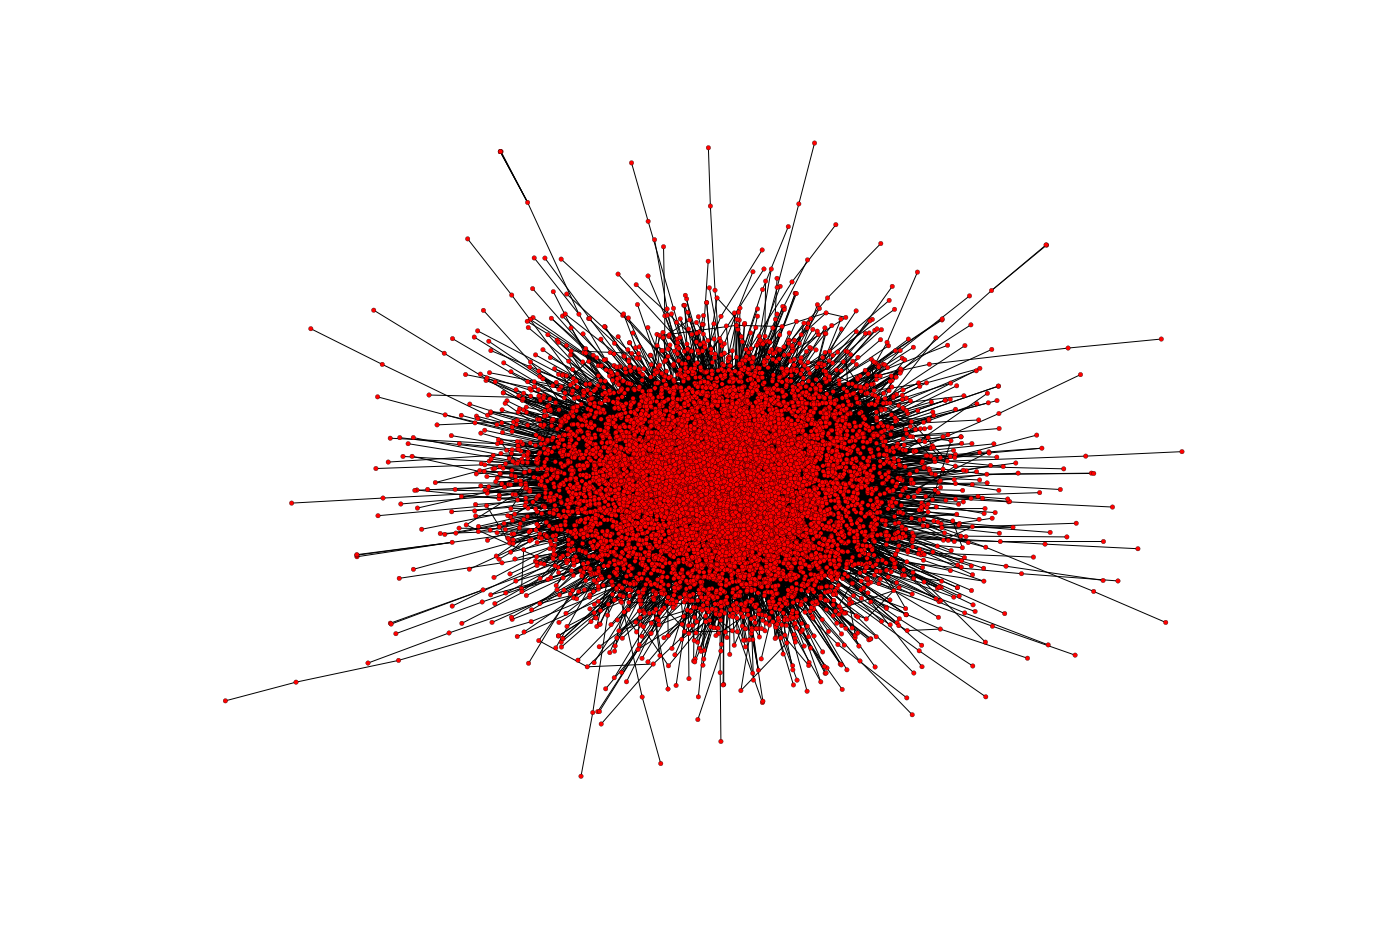

In [501]:
pos = nx.spring_layout(small_graph)
fig, ax = plt.subplots(figsize=(24,16))
nx.draw(small_graph, pos, edge_list=G.edges(), ax=ax, 
        node_size=[20 for x in small_graph.nodes()], hold=True)

Посчитаем некоторые характеристики нашего графа

## Диаметр, центр и радиус

диаметром графа называется максимальное расстояние между двумя его вершинами. 


In [502]:
print('Диаметр графа:', nx.diameter(small_graph))

Диаметр графа: 11


Интерпретация

### Центр графа

Центр графа — это любая вершина, такая, что расстояние от нее до наиболее отдаленной вершины минимально. Центром графа может быть одна вершина или несколько вершин. Или проще. Центр графа — вершина, эксцентриситет (расстояние от этой вершины до самой удаленной от нее) которой равен радиусу. 


In [44]:
center_nodes = nx.center(small_graph)
print('Центр графа:', len(center_nodes))

Центр графа: 407


In [51]:
school_users[school_users.uid.isin(center_nodes)][['uid','first_name', 'last_name']].to_csv('school_center_users_info.csv')

In [212]:
center_graph = users_connections[users_connections.Source.isin(np.random.choice(center_nodes, 8))]
center_g = nx.from_pandas_dataframe(center_graph, 'Source', 'Target')

In [65]:
center_graph.to_csv('school_connections_class.csv')

In [213]:
center_graph.shape

(1021, 30)

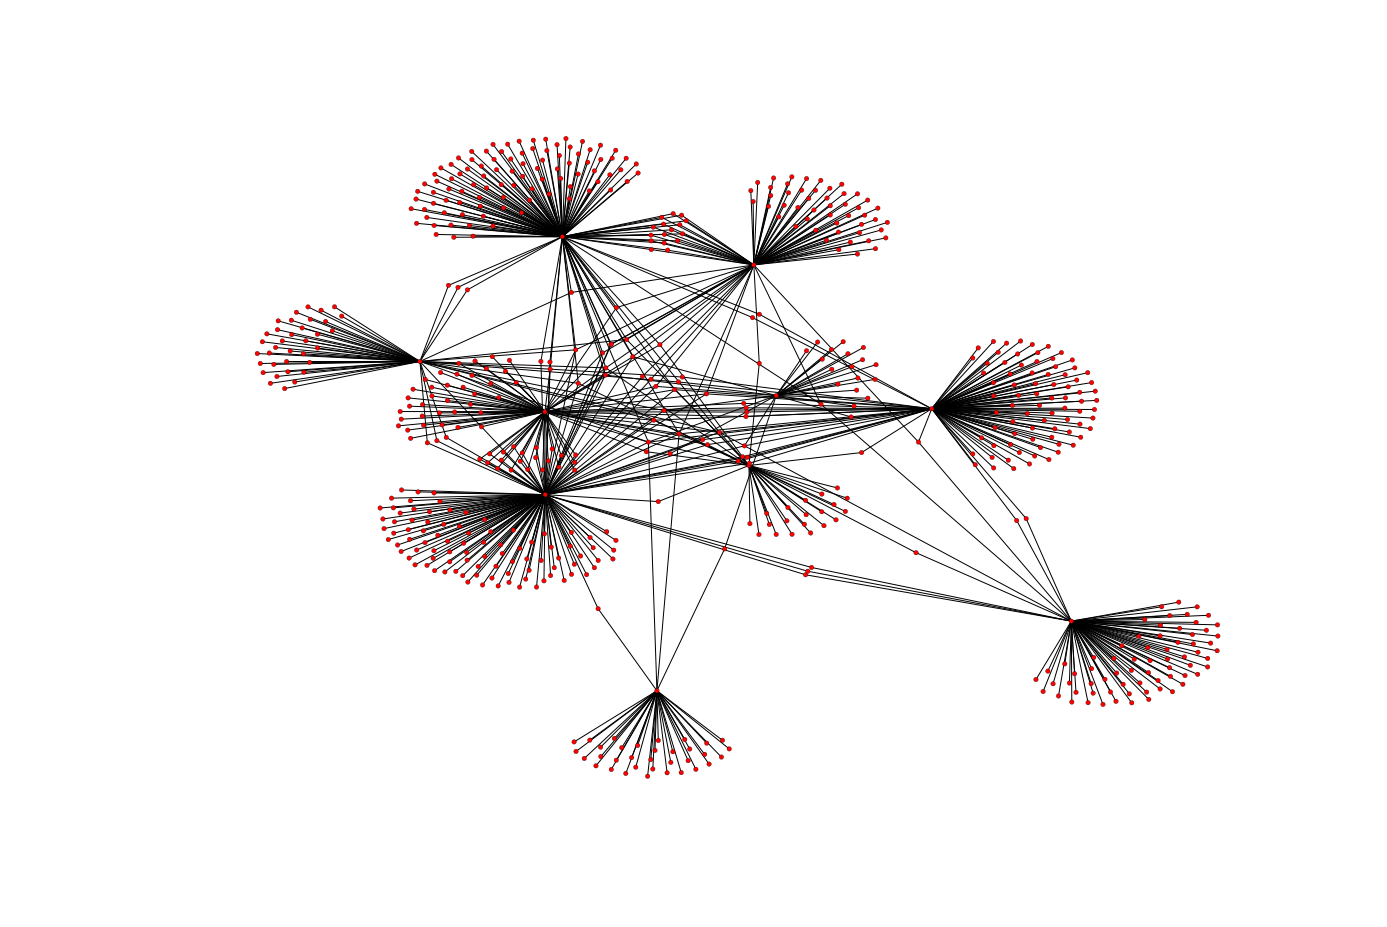

In [201]:
pos = nx.spring_layout(center_g)
fig, ax = plt.subplots(figsize=(24,16))
nx.draw(center_g, pos, ax=ax, node_size=[20 for x in center_g.nodes()], hold=True)

### Радиус графа

Радиус графа — это наименьший из эксцентриситетов всех вершин.


In [82]:
print('Радиус графа:', nx.radius(center_g))

Радиус графа: 3


Интерпретация

## Degree

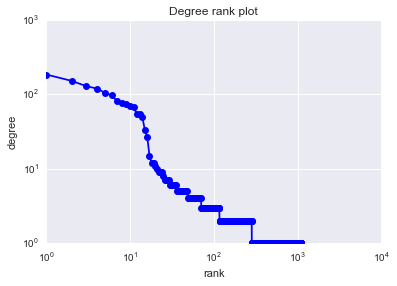

In [83]:
degree_sequence=sorted(nx.degree(center_g).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

## Центральности

### Closeness centrality

In [223]:
closeness = nx.closeness_centrality(center_g)

Посмотрим, у кого самая высокая центральность

In [244]:
closeness_sorted = sorted(closeness.items(), key=lambda t: t[1], reverse=True)
popular_users = dict(closeness_sorted[:5]).keys()

In [251]:
school_users[school_users['uid'].isin(popular_users)][['first_name', 'last_name']]

,first_name,last_name
400,Georgy,Katrechko
1202,Ivan,Shunin
2402,Sergievskaya,Yana
4759,Andrey,Grechko
5185,Grigory,Tarasevich


Plot hist

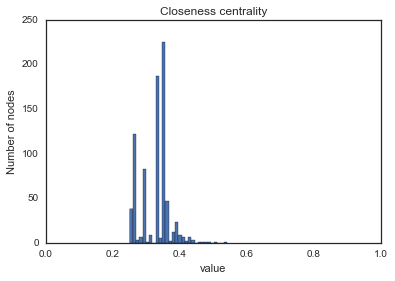

In [237]:
closeness_sequence=sorted(closeness.values(),reverse=True) # degree sequence
dmax=max(closeness_sequence)

plt.hist(closeness_sequence, bins=30);
plt.title("Closeness centrality")
plt.ylabel("Number of nodes")
plt.xlabel("value")
plt.xlim([0,1]);

Вывод

### Betweeness centrality

In [230]:
betweeness = nx.betweenness_centrality(center_g)

In [252]:
betweeness_sorted = sorted(betweeness.items(), key=lambda t: t[1], reverse=True)
betweeness_users = dict(betweeness_sorted[:5]).keys()

In [253]:
school_users[school_users['uid'].isin(betweeness_users)][['first_name', 'last_name']]

,first_name,last_name
400,Georgy,Katrechko
1560,Alevtina,Borodulina
2560,Olya,Evdokimova
4759,Andrey,Grechko
5152,Alexandra,Sivtsova


Plot hist

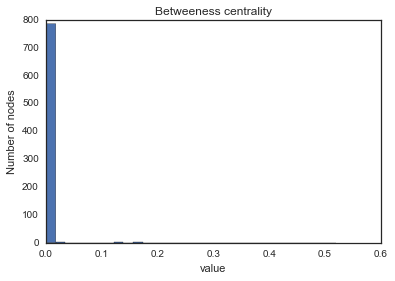

In [238]:
betweeness_sequence=sorted(betweeness.values(),reverse=True) # degree sequence
dmax=max(betweeness_sequence)

plt.hist(betweeness_sequence, bins=30);
plt.title("Betweeness centrality")
plt.ylabel("Number of nodes")
plt.xlabel("value")
#plt.xlim([0,1]);

Вывод

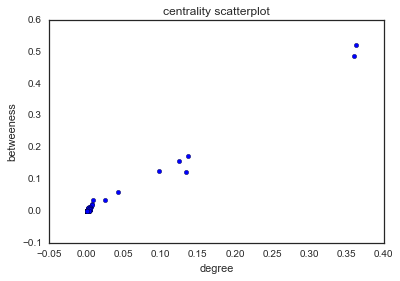

In [297]:
deg_centrality = nx.degree_centrality(center_g)
btw_centrality = nx.betweenness_centrality(center_g)

deg_cent_sorted = [i[1] for i in sorted(zip(deg_centrality.keys(), deg_centrality.values()))]
btw_cent_sorted = [i[1] for i in sorted(zip(btw_centrality.keys(), btw_centrality.values()))]

plt.scatter(deg_cent_sorted, btw_cent_sorted)
plt.xlabel('degree')
plt.ylabel('betweeness')
plt.title('centrality scatterplot')

## Сообщества в графе

In [298]:
nx.average_clustering(center_g)

0.07230868719802512

In [299]:
partition = community.best_partition(center_g)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(center_g)

Присвоим вершинам соотвестующий им кластер

In [215]:
nx.set_node_attributes(center_g, 'cluster', partition)

Далее мы можем раскрасить вершины цветом соответсующего кластера

In [217]:
cluster_nodes = {}
for cluster in set(partition.values()):
    nodes = []
    for key, value in partition.items():
        if value == cluster:
            nodes.append(key)
    cluster_nodes[cluster] = nodes       

In [218]:
cluster_nodes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

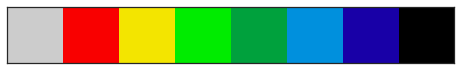

In [306]:
clusters = list(cluster_nodes.keys())
cluster_colors = [x/max(clusters) for x in clusters]
colors = [rgb2hex(color) for color in plt.cm.nipy_spectral_r(cluster_colors)]
sns.palplot(colors)

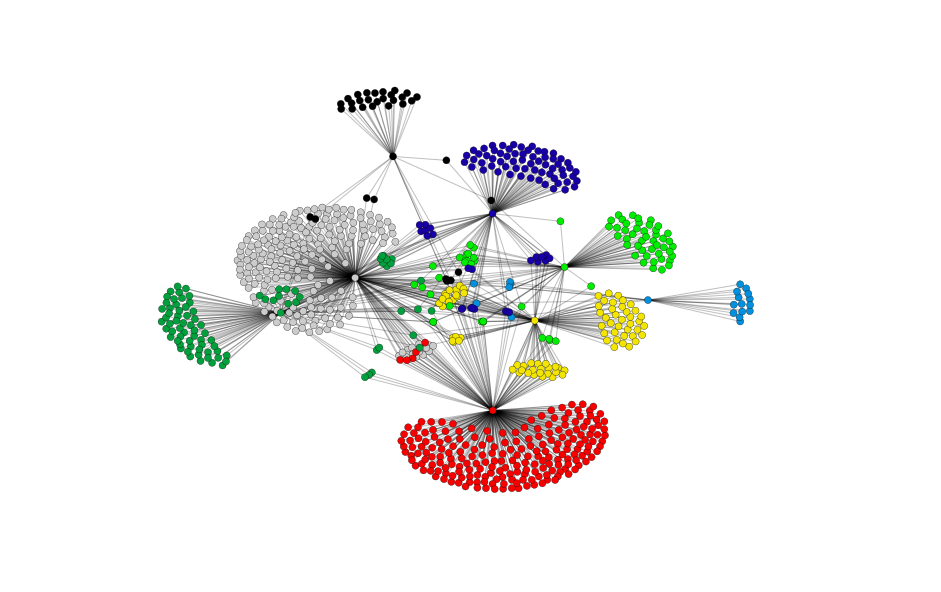

In [307]:
fig, ax = plt.subplots(figsize=(16,10))

# Define layout
pos = nx.spring_layout(center_g)

for cluster in clusters:
    
    color = colors[cluster]
    nodelist = cluster_nodes[cluster]
    nx.draw_networkx_nodes(center_g, pos, nodelist=nodelist, node_color=color,
                           node_size=[50 for x in nodelist])


nx.draw_networkx_edges(center_g, pos, edge_list=center_g.edges(), alpha=0.25)
ax.set_axis_off()

## Кратчайшие пути между участниками

In [308]:
def extract_path_edges(G, source, target):
    # Check to make sure that a path does exists between source and target.
    if nx.has_path(G, source, target):
        nodes = nx.shortest_path(G, source, target)
        newG = G.subgraph(nodes)
        return newG

    else:
        raise Exception('Path does not exist between nodes {0} and {1}.'.format(source, target))

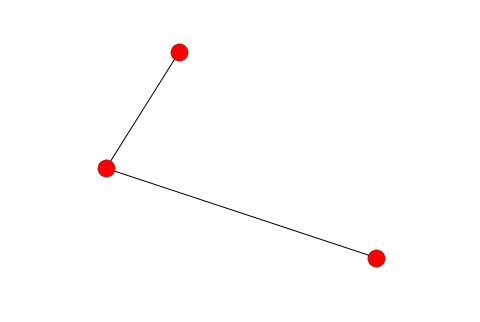

In [309]:
newG = extract_path_edges(center_g, 162449, 90983723)
nx.draw(newG)

## Структуры в графе

### Клики

In [290]:
list(nx.find_cliques(center_g))

[[44533767, 321892],
 [53745674, 321892],
 [5206027, 959337],
 [3620876, 321892],
 [13002775, 959337],
 [6172, 959337],
 [143927327, 321892],
 [75556904, 321892],
 [10930220, 321892],
 [11206701, 14634370],
 [11206701, 321892],
 [120854573, 2069293],
 [12349501, 959337],
 [12349501, 321892],
 [1583182, 321892],
 [2709592, 959337],
 [10254428, 321892],
 [187940956, 321892],
 [9592927, 2069293],
 [15312995, 14634370],
 [15312995, 321892],
 [5273702, 321892],
 [13826150, 14634370],
 [13826150, 321892],
 [10926187, 321892],
 [2556015, 321892],
 [229275765, 321892],
 [72642677, 321892],
 [72642677, 2069293],
 [72642677, 3952279],
 [19030141, 2069293],
 [6285446, 4953448],
 [6285446, 321892],
 [2162827, 959337],
 [473229, 321892],
 [4214926, 321892],
 [143616141, 3475064],
 [70219923, 321892],
 [56443031, 3952279],
 [10746007, 2069293],
 [23470233, 959337],
 [28348584, 14634370],
 [133081263, 2069293],
 [1005745, 4953448],
 [1005745, 321892],
 [2672818, 2069293],
 [12716218, 321892],
 [19220

In [ ]:
def get_triangles(G, node):
    neighbors1 = set(G.neighbors(node))
    triangle_nodes = set()
    triangle_nodes.add(node)
    """
    Fill in the rest of the code below.
    """
    for nbr1, nbr2 in combinations(neighbors1, 2):
        if G.has_edge(nbr1, nbr2):
            triangle_nodes.add(nbr1)
            triangle_nodes.add(nbr2)
    return triangle_nodes

In [311]:
get_triangles(center_g, 6172)

{6172}

In [262]:
def get_open_triangles(G, node):
    """
    There are many ways to represent this. One may choose to represent
    only the nodes involved in an open triangle; this is not the 
    approach taken here.
    
    Rather, we have a code that explicitly enumrates every open triangle present.
    """
    open_triangle_nodes = []
    neighbors = set(G.neighbors(node))
    
    for n1, n2 in combinations(neighbors, 2):
        if not G.has_edge(n1, n2):
            open_triangle_nodes.append([n1, node, n2])
    
    return open_triangle_nodes

In [266]:
list(nx.find_cliques(center_g))

[[44533767, 321892],
 [53745674, 321892],
 [5206027, 959337],
 [3620876, 321892],
 [13002775, 959337],
 [6172, 959337],
 [143927327, 321892],
 [75556904, 321892],
 [10930220, 321892],
 [11206701, 14634370],
 [11206701, 321892],
 [120854573, 2069293],
 [12349501, 959337],
 [12349501, 321892],
 [1583182, 321892],
 [2709592, 959337],
 [10254428, 321892],
 [187940956, 321892],
 [9592927, 2069293],
 [15312995, 14634370],
 [15312995, 321892],
 [5273702, 321892],
 [13826150, 14634370],
 [13826150, 321892],
 [10926187, 321892],
 [2556015, 321892],
 [229275765, 321892],
 [72642677, 321892],
 [72642677, 2069293],
 [72642677, 3952279],
 [19030141, 2069293],
 [6285446, 4953448],
 [6285446, 321892],
 [2162827, 959337],
 [473229, 321892],
 [4214926, 321892],
 [143616141, 3475064],
 [70219923, 321892],
 [56443031, 3952279],
 [10746007, 2069293],
 [23470233, 959337],
 [28348584, 14634370],
 [133081263, 2069293],
 [1005745, 4953448],
 [1005745, 321892],
 [2672818, 2069293],
 [12716218, 321892],
 [19220

In [264]:
print(get_open_triangles(G, 5185))
len(get_open_triangles(G, 5185))

NetworkXError: The node 5185 is not in the graph.

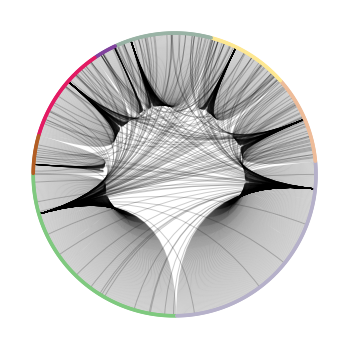

In [222]:
c = nv.CircosPlot(center_g, node_color='cluster', node_grouping='cluster')
c.draw()

170
61


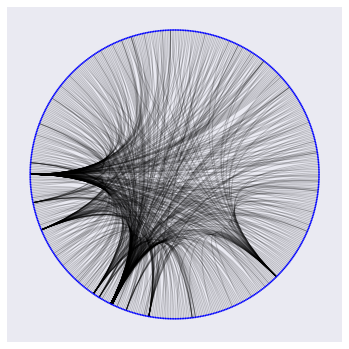

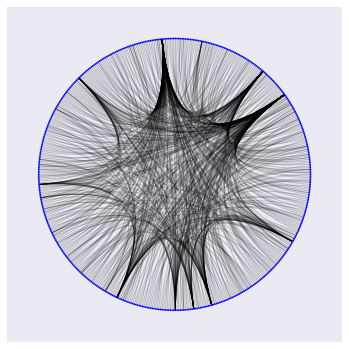

In [148]:
edgeprops = {'alpha': 0.05}
nodeprops = {'radius': 0.05}
#fig, ax = plt.subplots(4,4,figsize=(15,7))
#ax = ax.ravel()

for cluster in clusters[:2]:
    # Pick out only the edges associated with the current cluster
    nodelist = cluster_nodes[cluster]
    print(len(nodelist))
    center_g_sub = nx.from_pandas_dataframe(users_connections[users_connections.Source.isin(nodelist[:10])],
                                            'Source', 'Target')
    c = nv.CircosPlot(center_g_sub, nodeprops=nodeprops)
    c.draw()
    #axes.set_aspect('equal') # Keep our axes aspect ratio 1:1, thus keeping node arrangements circular
    #axes.set_title('Cluster #{}'.format(cluster))

In [149]:
center_g.nodes(data=True)

[(232671745, {'cluster': 0}),
 (15589387, {'cluster': 1}),
 (139080716, {'cluster': 1}),
 (7730191, {'cluster': 2}),
 (4473054, {'cluster': 3}),
 (2179929, {'cluster': 2}),
 (10746906, {'cluster': 2}),
 (7856155, {'cluster': 2}),
 (4507677, {'cluster': 3}),
 (86069278, {'cluster': 4}),
 (1825824, {'cluster': 0}),
 (20571173, {'cluster': 0}),
 (5302310, {'cluster': 1}),
 (133067441, {'cluster': 2}),
 (9350184, {'cluster': 4}),
 (101655594, {'cluster': 3}),
 (46918699, {'cluster': 4}),
 (10930220, {'cluster': 2}),
 (11206701, {'cluster': 2}),
 (56660015, {'cluster': 3}),
 (133168, {'cluster': 2}),
 (35294260, {'cluster': 0}),
 (2353207, {'cluster': 3}),
 (1797127, {'cluster': 0}),
 (963641, {'cluster': 1}),
 (12724575, {'cluster': 3}),
 (33734717, {'cluster': 1}),
 (135193132, {'cluster': 2}),
 (112274497, {'cluster': 4}),
 (3227659, {'cluster': 3}),
 (50633796, {'cluster': 2}),
 (44202055, {'cluster': 1}),
 (33171528, {'cluster': 3}),
 (3620876, {'cluster': 2}),
 (8353870, {'cluster': 2

In [156]:
nodes = dict()
nodes['group1'] = [(n,d) for n, d in center_g.nodes(data=True) if d["cluster"] == 0]
nodes['group2'] = [(n,d) for n, d in center_g.nodes(data=True) if d["cluster"] == 1]
nodes['group3'] = [(n,d) for n, d in center_g.nodes(data=True) if d["cluster"] == 2]

In [167]:
edges = dict()
edges['group1'] = [(u,v,d) for u,v,d in G.edges(data=True) if  v in nodes['group1']]
edges['group2'] = [(u,v,d) for u,v,d in G.edges(data=True) if v in nodes['group2']]
edges['group3'] = [(u,v,d) for u,v,d in G.edges(data=True) if v in nodes['group3']]

In [168]:
edges_cmap = dict()
edges_cmap['group1'] = 'green'
edges_cmap['group2'] = 'red'
edges_cmap['group3'] = 'blue'

In [169]:
nodes_cmap = dict()
nodes_cmap['group1'] = 'green'
nodes_cmap['group2'] = 'red'
nodes_cmap['group3'] = 'blue'

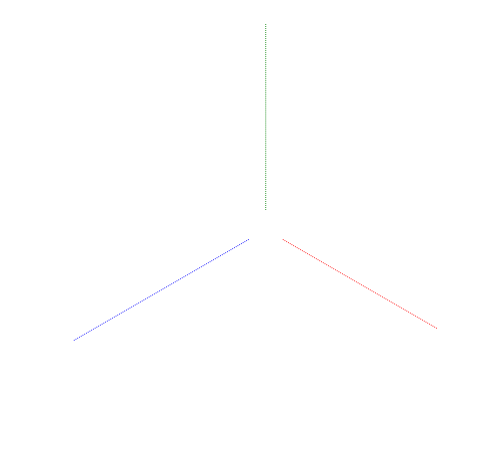

In [170]:
h = HivePlot(nodes, edges, node_colormap=nodes_cmap, edge_colormap=edges_cmap)
h.draw()

In [26]:
def get_friends_count(x):
    if x:
        return x['friends']
    
def get_pages_count(x):
    if x:
        return x['pages']
    
def get_followers_count(x):
    if x:
        return x['followers']

In [27]:
school_users['friends_count'] = school_users['counters'].apply(lambda x: get_friends_count(x))

In [28]:
school_users['pages_count'] = school_users['counters'].apply(lambda x: get_pages_count(x))

In [29]:
school_users['followers_count'] = school_users['counters'].apply(lambda x: get_followers_count(x))

In [40]:
users_connections.to_csv('school_connections.csv')

In [171]:
school_users.columns

Index(['activity', 'bdate', 'can_post', 'can_see_all_posts',
       'can_write_private_message', 'city', 'counters', 'country',
       'deactivated', 'faculty', 'faculty_name', 'first_name', 'graduation',
       'has_mobile', 'home_phone', 'last_name', 'last_seen', 'mobile_phone',
       'nickname', 'occupation', 'online', 'online_app', 'online_mobile',
       'photo', 'photo_big', 'photo_medium', 'relation', 'relation_partner',
       'screen_name', 'sex', 'status_audio', 'timezone', 'uid', 'universities',
       'university', 'university_name', 'country_name', 'city_name',
       'occupation_type', 'occupation_name', 'Source', 'friends_count',
       'pages_count', 'followers_count', 'bdate_year'],
      dtype='object')

In [173]:
school_users[['activity', 'bdate', 'can_post', 'can_see_all_posts',
       'can_write_private_message', 'city', 'country',
       'deactivated', 'faculty', 'faculty_name', 'first_name', 'graduation',
       'has_mobile', 'home_phone', 'last_name', 'mobile_phone',
       'nickname',  'online', 'online_app', 'online_mobile',
       'photo', 'photo_big', 'photo_medium', 'relation', 'relation_partner',
       'screen_name', 'sex', 'status_audio', 'timezone', 'uid',
       'university', 'university_name', 'country_name', 'city_name',
       'occupation_type', 'occupation_name', 'Source', 'friends_count',
       'pages_count', 'followers_count', 'bdate_year']].to_csv('school_users_info.csv')